In [1]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

# from src.model_managers.detr_model_manager import DETRModelManager
from src.dataset_loaders.download_openimages import OpenImagesLoader
# from src.dataset_loaders.detr_dataset_processor import DETRDatasetProcessor
from tqdm import tqdm, tqdm_notebook


from transformers import DetrForObjectDetection, DetrImageProcessor


In [2]:

# Device Configuration:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(f"Device being used: {device}")

Device being used: cuda


In [3]:
import os
import torchvision.transforms.v2 as transforms
from openimages.download import download_dataset
import random
import shutil
import torch
from torch.utils.data import DataLoader
from PIL import Image as PILImage
from torchvision import tv_tensors
from torchvision.transforms.v2 import Resize
from torchvision.ops import box_convert


class DETRDatasetProcessor():

    def __init__(self, random_seed = 101, batch_size = 128, perc_keep = 1.0, num_images_per_class=500):
        self.data_dir = os.path.join("data", "openimages")  # Directory in which dataset resides
        self.random_seed = random_seed
        self.batch_size = batch_size
        self.perc_keep = perc_keep  # Percentage of dataset to be kept (number between 0 and 1)
        self.num_images_per_class = num_images_per_class

        self.transforms_all = transforms.Compose(
            [
                Resize((512, 512)),
            ]
        )

        self.transforms_img = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet's normalization statistics
            ]
        )

        self.classes = [
            "Hot dog", "French fries", "Waffle", "Pancake", "Burrito", "Pretzel",
            "Popcorn", "Cookie", "Muffin", "Ice cream", "Cake", "Candy",
            "Guacamole", "Apple", "Grape", "Common fig", "Pear",
            "Strawberry", "Tomato", "Lemon", "Banana", "Orange", "Peach", "Mango",
            "Pineapple", "Grapefruit", "Pomegranate", "Watermelon", "Cantaloupe",
            "Egg (Food)", "Bagel", "Bread", "Doughnut", "Croissant",
            "Tart", "Mushroom", "Pasta", "Pizza", "Squid",
            "Oyster", "Lobster", "Shrimp", "Crab", "Taco", "Cooking spray",
            "Cucumber", "Radish", "Artichoke", "Potato", "Garden Asparagus",
            "Pumpkin", "Zucchini", "Cabbage", "Carrot", "Salad",
            "Broccoli", "Bell pepper", "Winter melon", "Honeycomb",
            "Hamburger", "Submarine sandwich", "Cheese", "Milk", "Sushi"
        ]

        # Creating a dictionary mapping each class name to an index:
        self.class_2_index = {}
        for i, class_name in enumerate(self.classes):
            self.class_2_index[class_name.lower()] = i

        # Creating a dictionary mapping each class index to its corresponding class name:
        self.index_2_class = {}
        for k, v in self.class_2_index.items():
            self.index_2_class[v] = k

        self.train_dir = os.path.join(self.data_dir, "train") # Directory in which train dataset resides
        self.val_dir = os.path.join(self.data_dir, "val") # Directory in which validation dataset resides
        self.test_dir = os.path.join(self.data_dir, "test") # Directory in which test dataset resides

        self.train_red_dir = os.path.join(self.data_dir, "train_reduced") # Directory in which reduced train dataset resides
        self.val_red_dir = os.path.join(self.data_dir, "val_reduced") # Directory in which reduced validation dataset resides
        self.test_red_dir = os.path.join(self.data_dir, "test_reduced") # Directory in which reduced test dataset resides


    def download_data(self, annotation_format='darknet'):
        # download_dataset(self.data_dir, self.classes, annotation_format=annotation_format, limit=5)
        
        for class_name in self.classes:
            print(f'Attempting to download {class_name} data')
            if not os.path.isdir(os.path.join(self.data_dir, class_name.lower())):
                try:
                    download_dataset(self.data_dir, [class_name], annotation_format=annotation_format, limit=5)
                except Exception as e:
                    print(f'An exception occurred for {class_name}. ERROR: {e}')
            else:
                print(f'Skipped {class_name}, data already downloaded')


    def split_data(self, keep_class_dirs=True):

        """ This function splits the downloaded Open Image dataset, and splits each class into training, validation, and testing sets.
            This function assumes that the required data has already been downloaded."""

        # Setting the random seed:
        random.seed(self.random_seed)
        
        splits = ["train", "val", "test"]

        # Making folders for each of the splits:
        for split in splits:
            split_dir = os.path.join(self.data_dir, split)
            os.makedirs(split_dir, exist_ok=True)

        # Iterating through each class:
        for class_cur in self.classes:
            print(f'Splitting data for class {class_cur}')

            # Getting directories for the images and annotations for each class:
            imgs_dir = os.path.join(self.data_dir, class_cur.lower(), "images")
            anns_dir = os.path.join(self.data_dir, class_cur.lower(), "darknet")

            # Ensuring each class has images and annotations:
            if not imgs_dir:
                raise Exception(f'Images do not exist for {class_cur}!')

            if not anns_dir:
                raise Exception(f'Annotations do not exist for {class_cur}!')

            class_imgs = os.listdir(imgs_dir) # Images for current class
            class_anns = os.listdir(anns_dir) # Annotations for current class
            class_imgs.sort()
            class_anns.sort()

            num_imgs = len(class_imgs) # Number of images and annotations for current class
            
            # Shuffling data:
            inds_list = list(range(num_imgs)) # List of indices ranging for the total number of images
            random.shuffle(inds_list) # Shuffling indices list
            class_imgs = [class_imgs[i] for i in inds_list] # Shuffling class images according to shuffled inds_list
            class_anns = [class_anns[i] for i in inds_list] # Shuffling class annotations according to shuffled inds_list

            ind_train = int(0.8 * num_imgs) # Ending index for the training images
            ind_val = ind_train + int(0.1 * num_imgs) # Ending index for the validation images

            # Splitting images into training, validation, and testing:
            train_imgs = class_imgs[:ind_train]
            val_imgs = class_imgs[ind_train:ind_val]
            test_imgs = class_imgs[ind_val:]

            all_imgs = [train_imgs, val_imgs, test_imgs] # All images
            
            # Splitting annotations into training, validation, and testing:
            train_anns = class_anns[:ind_train]
            val_anns = class_anns[ind_train:ind_val]
            test_anns = class_anns[ind_val:]

            all_anns = [train_anns, val_anns, test_anns] # All annotations
            
            # Looping through all split types and corresponding split images:
            for split_type, split_imgs, split_anns in zip(splits, all_imgs, all_anns):
                if keep_class_dirs:
                    # Creating each split directory for images and annotations for current class:
                    split_dir_img = os.path.join(self.data_dir, split_type, class_cur.lower(), "images")
                    split_dir_ann = os.path.join(self.data_dir, split_type, class_cur.lower(), "annotations")
                else:
                    split_dir_img = os.path.join(self.data_dir, split_type, "images")
                    split_dir_ann = os.path.join(self.data_dir, split_type, "annotations")

                os.makedirs(split_dir_img, exist_ok=True)
                os.makedirs(split_dir_ann, exist_ok=True)

                # Copying each image from initial directory to corresponding split directory for each split:
                for img, ann in zip(split_imgs, split_anns):
                    shutil.copy(os.path.join(imgs_dir, img), os.path.join(split_dir_img, img))
                    shutil.copy(os.path.join(anns_dir, ann), os.path.join(split_dir_ann, ann))

                    # Code to replace each original class label (which is 0) to the class label as found in self.class_2_index:
                    ann_file_cur_dir = os.path.join(split_dir_ann, ann) # File path of current annotation file
                    with open(ann_file_cur_dir, 'r') as file:
                        objects = file.readlines()

                        new_labels = []
                        for obj in objects:
                            obj_items = obj.split()
                            new_class_label = self.class_2_index[class_cur.lower()]
                            obj_items[0] = str(new_class_label)

                            obj_new = ' '.join(obj_items) + '\n'
                            new_labels.append(obj_new)
                    
                    with open(ann_file_cur_dir, 'w') as file:
                        file.writelines(new_labels)
                            

    def split_data_reduced(self, keep_class_dirs=True):

        """ This function splits the downloaded Open Image dataset, and splits each class into training, validation, and testing sets.
            This function assumes that the required data has already been downloaded.
            This function reduces the dataset by self.keep_perc. """

        # Setting the random seed:
        random.seed(self.random_seed)
        
        splits = ["train_reduced", "val_reduced", "test_reduced"]
        
        # Making folders for each of the splits:
        for split in splits:
            split_dir = os.path.join(self.data_dir, split)
            os.makedirs(split_dir, exist_ok=True)

        # Iterating through each class:
        for class_cur in self.classes:
            print(f'Splitting data for class {class_cur}')

            # Getting directories for the images and annotations for each class:
            imgs_dir = os.path.join(self.data_dir, class_cur.lower(), "images")
            anns_dir = os.path.join(self.data_dir, class_cur.lower(), "darknet")

            # Ensuring each class has images and annotations:
            if not imgs_dir:
                raise Exception(f'Images do not exist for {class_cur}!')

            if not anns_dir:
                raise Exception(f'Annotations do not exist for {class_cur}!')

            class_imgs = os.listdir(imgs_dir) # Images for current class
            class_anns = os.listdir(anns_dir) # Annotations for current class
            class_imgs.sort()
            class_anns.sort()

            num_imgs = len(class_imgs) # Number of images and annotations for current class
            
            if self.perc_keep != 1.00 and num_imgs > 50:
                num_imgs = int(num_imgs * self.perc_keep)
                class_imgs = class_imgs[:num_imgs]
                class_anns = class_anns[:num_imgs]

            # Shuffling data:
            inds_list = list(range(num_imgs)) # List of indices ranging for the total number of images
            random.shuffle(inds_list) # Shuffling indices list
            class_imgs = [class_imgs[i] for i in inds_list] # Shuffling class images according to shuffled inds_list
            class_anns = [class_anns[i] for i in inds_list] # Shuffling class annotations according to shuffled inds_list

            ind_train = int(0.8 * num_imgs) # Ending index for the training images
            ind_val = ind_train + int(0.1 * num_imgs) # Ending index for the validation images

            # Splitting images into training, validation, and testing:
            train_imgs = class_imgs[:ind_train]
            val_imgs = class_imgs[ind_train:ind_val]
            test_imgs = class_imgs[ind_val:]

            all_imgs = [train_imgs, val_imgs, test_imgs] # All images
            
            # Splitting annotations into training, validation, and testing:
            train_anns = class_anns[:ind_train]
            val_anns = class_anns[ind_train:ind_val]
            test_anns = class_anns[ind_val:]

            all_anns = [train_anns, val_anns, test_anns] # All annotations
            
            # Looping through all split types and corresponding split images:
            for split_type, split_imgs, split_anns in zip(splits, all_imgs, all_anns):
                if keep_class_dirs:
                    # Creating each split directory for images and annotations for current class:
                    split_dir_img = os.path.join(self.data_dir, split_type, class_cur.lower(), "images")
                    split_dir_ann = os.path.join(self.data_dir, split_type, class_cur.lower(), "annotations")
                else:
                    split_dir_img = os.path.join(self.data_dir, split_type, "images")
                    split_dir_ann = os.path.join(self.data_dir, split_type, "annotations")

                os.makedirs(split_dir_img, exist_ok=True)
                os.makedirs(split_dir_ann, exist_ok=True)

                # Copying each image from initial directory to corresponding split directory for each split:
                for img, ann in zip(split_imgs, split_anns):
                    shutil.copy(os.path.join(imgs_dir, img), os.path.join(split_dir_img, img))
                    shutil.copy(os.path.join(anns_dir, ann), os.path.join(split_dir_ann, ann))

                    # Code to replace each original class label (which is 0) to the class label as found in self.class_2_index:
                    ann_file_cur_dir = os.path.join(split_dir_ann, ann) # File path of current annotation file
                    with open(ann_file_cur_dir, 'r') as file:
                        objects = file.readlines()

                        new_labels = []
                        for obj in objects:
                            obj_items = obj.split()
                            new_class_label = self.class_2_index[class_cur.lower()]
                            obj_items[0] = str(new_class_label)

                            obj_new = ' '.join(obj_items) + '\n'
                            new_labels.append(obj_new)
                    
                    with open(ann_file_cur_dir, 'w') as file:
                        file.writelines(new_labels)

        print(f"Dataset has been reduced!")


    def see_class_labels(self):
        """ Simple function to determine if all of the images have just one class in them. """

        # Change the split to "train", "val", or "test" to choose which directory you need to test:
        anns_dir =  os.path.join(self.data_dir, "test", "annotations")

        ann_files = os.listdir(anns_dir)

        for ann_file in ann_files:
            ann_file_dir = os.path.join(anns_dir, ann_file)

            with open(ann_file_dir, 'r') as file:
                objects = file.readlines()

                for obj in objects:
                    class_label = int(obj.split()[0])
                    if class_label != 0:
                        print(f"Object {obj} in file {ann_file}")





    def make_dataloader(self, split_name):
        """ Function to create a DataLoader object that's compatible with Facebook's DETR model.
        
        Inputs:
        split_name (str) - must be one of the following: "train", "train_reduced", "val", "val_reduced", "test", "test_reduced

        Outputs:
        dl (DataLoader) - DataLoader object

        """

        def collate_fn(data):
            """ Defining the collate function to pad and return images and list of annotations,
                as object-detection can have variable image sizes and variable number of objects
                in each image. 
            """

            # Extracting the images and corresponding annotations:
            imgs, anns = zip(*data)

            return torch.stack(imgs), anns        

        imgs_dir = os.path.join(self.data_dir, split_name, "images")
        anns_dir = os.path.join(self.data_dir, split_name, "annotations")

        # Lists of all the images and corresponding annotation files in the selected directory:
        imgs_list = os.listdir(imgs_dir)
        anns_list = os.listdir(anns_dir)

        dataset = []
        # Iterating through each image and annotation pair:
        for img_cur, ann_cur in zip(imgs_list, anns_list):
            
            # Directories of current image and annotation:
            img_cur_dir = os.path.join(imgs_dir, img_cur)
            ann_cur_dir = os.path.join(anns_dir, ann_cur)

            # Reading image:
            img_pil = PILImage.open(img_cur_dir).convert("RGB")
            img_size_orig = img_pil.size # (width, height) format
            # img_tv = TVImage(torch.tensor(img_pil).permute(2, 0, 1))

            ann_list = []
            # Reading annotation file:
            with open(ann_cur_dir, 'r') as file:

                objects = file.readlines()

                # Iterating through each object in the image (all assumed to equal to the target class):
                for obj in objects:
                    obj_items = obj.split()
                    class_label = int(obj_items[0]) # Class label
                    x_cent = float(obj_items[1]) # x-coordinate of bounding box's center
                    y_cent = float(obj_items[2]) # y-coordinate of bounding box's center
                    box_width = float(obj_items[3]) # Width of bounding box
                    box_height = float(obj_items[4]) # Height of bounding box

                    # Appending the bounding box information to the list of bounding box information:
                    ann_list.append([x_cent, y_cent, box_width, box_height])

                # Converting list of bounding box information to a PyTorch tensor:
                box_tensor = torch.tensor(ann_list, dtype=torch.float)

            # box_tensor_convert = box_convert(box_tensor, in_fmt='cxcywh', out_fmt='xyxy') # Converting bounding boxes from CXCYWH format to XYXY format to make it compatible with DETR model

            # Bounding box object for current annotation file:
            # bounding_boxes = tv_tensors.BoundingBoxes(box_tensor_convert, format="XYXY", canvas_size=img_size_orig)
            bounding_boxes = tv_tensors.BoundingBoxes(box_tensor, format="CXCYWH", canvas_size=img_size_orig)


            # Applying transformations to bounding boxes and image:
            img_trans = self.transforms_all(img_pil) # Applying the general transformations to the image
            bb_trans = self.transforms_all(bounding_boxes) # Applying the general transformations to the image's corresponding bounding boxes
            img_trans = self.transforms_img(img_trans) # Applying the image-specific transformations to the image (tensor conversion and normalization)

            num_labels = bb_trans.shape[0] # Number of objects
            labels_tensor = torch.ones(num_labels, dtype=torch.long) * class_label # Creating a labels tensor

            ann_dict = {"boxes": bb_trans, "class_labels": labels_tensor}

            info_tuple = (img_trans, ann_dict)
            dataset.append(info_tuple)
        

        dataset_wrapper = DETRDataset(dataset)
        dl = DataLoader(dataset_wrapper, batch_size=self.batch_size, shuffle=True, collate_fn=collate_fn)

        return dl


class DETRDataset():
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, ind):
        return self.dataset[ind]

    def __len__(self):
        return len(self.dataset)
    


In [4]:
# Data Configuration & Hyperparameters:
PERC_KEEP = 0.10 # Proportion of data from datasets to keep
BATCH_SIZE = 16 # Batch size
EPOCHS = 50 # Number of epochs to train the model for
LEARNING_RATE = 1e-4 # Learning rate

In [5]:
### Loading Open Images Dataset:

# Initializing the DETRDatasetProcessor class:
detr_processor = DETRDatasetProcessor(batch_size=BATCH_SIZE, perc_keep=PERC_KEEP)
print(f"Number of classes: {len(detr_processor.classes)}")

# Downloading the Open Images Dataset in darknet format:
# detr_processor.download_data()

# Splitting the downloaded data into training, validation, and test sets:
# detr_processor.split_data(keep_class_dirs=False)

# Splitting the downloaded data into reduced training, validation, and test sets:
# detr_processor.split_data_reduced(keep_class_dirs=False)

# Creating training, validation, and testing dataloaders:
train_set = detr_processor.make_dataloader("train_reduced")
val_set = detr_processor.make_dataloader("val_reduced")
test_set = detr_processor.make_dataloader("test_reduced")

print(f"Number of Batches in Training Set: {len(train_set)}")
print(f"Number of Batches in Validation Set: {len(val_set)}")
print(f"Number of Batches in Testing Set: {len(test_set)}")




Number of classes: 64
Number of Batches in Training Set: 82
Number of Batches in Validation Set: 10
Number of Batches in Testing Set: 14


In [6]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import copy
import numpy as np
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import torchvision
from torchvision import tv_tensors


class DETRModelManager:
    def __init__(self, model, im_processor, optimizer, scheduler=None, device=None):

        if device:
            self.device = device
        else:
            self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
        self.model = model.to(self.device)
        self.im_processor = im_processor
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.confidence_threshold = 0.02
        self.best_accuracy = 0.0
        self.best_loss = np.inf
        self.best_model_state_dict = None
        
        self.training_losses = None
        self.val_losses = None
        self.training_maps = None
        self.val_maps = None
        self.training_maps_50 = None
        self.val_maps_50 = None

    def train(self, training_data_loader, validation_data_loader = None, epochs=10):

        # Creating empty lists for the training and validation losses and mAP values:
        training_losses = []
        val_losses = []
        
        training_maps = []
        val_maps = []

        training_maps_50 = []
        val_maps_50 = []

        for epoch in tqdm(range(epochs)):
            display_epoch = epoch + 1

            self.model.train() # Putting the model (back) in training mode
            
            loss_epoch = 0
            map_epoch = MeanAveragePrecision()


            for idx, (imgs, anns) in enumerate(training_data_loader):
                
                # Extracting height and width of each image in the batch as well as batch size:
                batch_size = imgs.shape[0]
                img_height = 512
                img_width = 512
                img_sizes = [(img.shape[1], img.shape[2]) for img in imgs]
                
                # Moving all input and target tensors to device:
                inputs = {"pixel_values": imgs.to(self.device)} # Creating inputs for model
                anns = [{key: val.to(self.device) for key, val in ann.items()} for ann in anns]

                # Forward pass:
                output = self.model(**inputs, labels=anns)

                # Loss from current batch:
                loss = output.loss
                loss_epoch += loss

                # Backward pass:
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                ### Check MAP:
                pred = self.im_processor.post_process_object_detection(output, threshold=self.confidence_threshold, target_sizes=img_sizes)

                # Updating the mean average precision:
                # anns_target = [{"boxes": ann["boxes"], "labels": ann["class_labels"]} for ann in anns]
                anns_target = [{"boxes": tv_tensors.BoundingBoxes(ann["boxes"], format="XYXY", canvas_size=(img_height, img_width)), "labels": ann["class_labels"]} for ann in anns]
                map_epoch.update(pred, anns_target)

            if self.scheduler:
                # Stepping the learning rate scheduler:
                self.scheduler.step()

            # Calculating the average loss for current epoch:
            loss_epoch_avg = loss_epoch / len(training_data_loader)
            training_losses.append(loss_epoch_avg.cpu().cpu().detach().numpy())

            map_epoch_results = map_epoch.compute()
            print(f"Outputs From Last Batch: {output.loss_dict}")
            print(f"Epoch {display_epoch} Average Loss: {loss_epoch_avg}")
            print(f"Epoch {display_epoch} Mean Average Precision: {map_epoch_results['map']}, {map_epoch_results['map_50']}")

            training_maps.append(map_epoch_results['map'].cpu().detach().numpy())
            training_maps_50.append(map_epoch_results['map_50'].cpu().detach().numpy())

        
            if validation_data_loader:
                
                loss_val = 0
                map_val = MeanAveragePrecision()
                self.model.eval() # Putting the model in evaluation mode

                for idx, (imgs, anns) in enumerate(validation_data_loader):

                    # Extracting height and width of each image in the batch as well as batch size:
                    batch_size = imgs.shape[0]
                    img_height = 512
                    img_width = 512                 
                    img_sizes = [(img.shape[1], img.shape[2]) for img in imgs]

                    # Moving all input and target tensors to device:
                    inputs = {"pixel_values": imgs.to(self.device)}
                    anns = [{key: val.to(self.device) for key, val in ann.items()} for ann in anns]

                    with torch.no_grad():
                        
                        # Forward pass:
                        output = self.model(**inputs, labels=anns)

                        # Loss from current batch:
                        loss = output.loss
                        loss_val += loss # Adding current loss to the total loss across the batch

                        ### Check mAP:
                        pred = self.im_processor.post_process_object_detection(output, threshold=self.confidence_threshold, target_sizes=img_sizes)

                        # Updating the mean average precision:
                        anns_target = [{"boxes": tv_tensors.BoundingBoxes(ann["boxes"], format="XYXY", canvas_size=(img_height, img_width)), "labels": ann["class_labels"]} for ann in anns]
                        map_val.update(pred, anns_target)


            # Calculating average validation loss:
            loss_val_avg = loss_val / len(validation_data_loader)
            val_losses.append(loss_val_avg.cpu().detach().numpy())

            map_val_results = map_val.compute()

            val_maps.append(map_val_results['map'].cpu().detach().numpy())
            val_maps_50.append(map_val_results['map_50'].cpu().detach().numpy())

            print(f"Validation Loss: {loss_val_avg}")
            print(f"Validation Mean Average Precision: {map_val_results['map']}, {map_val_results['map_50']}")


            # Ensuring to save the model that achieves the lowest loss:
            if loss_val_avg < self.best_loss:
                self.best_loss = loss_val_avg
                self.best_model_state_dict = copy.deepcopy(self.model.state_dict())
        
        # Load best state after training for use:
        if self.best_model_state_dict is not None:
            self.model.load_state_dict(self.best_model_state_dict)

        # Setting the training and validation metric lists to their respective class variables:
        self.training_losses = training_losses
        self.val_losses = val_losses
        self.training_maps = training_maps
        self.val_maps = val_maps
        self.training_maps_50 = training_maps_50
        self.val_maps_50 = val_maps_50


    def test(self, test_data_loader):
        """ This function applies the trained model to the given test data. 
            It prints and returns the test accuracy.
        """

        loss_test = 0
        map_test = MeanAveragePrecision()
        self.model.eval() # Putting the model in evlauation mode

        for idx, (imgs, anns) in enumerate(test_data_loader):
            
            # Moving all input and target tensors to device:
            inputs = {"pixel_values": imgs.to(self.device)}
            anns = [{key: val.to(self.device) for key, val in ann.items()} for ann in anns]

            with torch.no_grad():
                
                # Forward pass:
                output = self.model(**inputs, labels=anns)

                # Loss from current batch:
                loss = output.loss
                loss_test += loss # Adding current loss to the total loss across the batch

                ### Check MAP:

                # Getting predictions:
                pred = []
                for ind in range(len(output.logits)):
                    pred_dict = {}
                    pred_dict['boxes'] = output.logits[ind]['boxes']
                    pred_dict['labels'] = output.logits[ind]['labels']
                    pred.append(pred_dict)

                # Updating the mean average precision
                map_test.update(pred, anns)

        # Calculating average validation loss:
        loss_test_avg = loss_test / len(test_data_loader)
        map_test_results = map_test.compute()

        print(f"Test Loss: {loss_test_avg}")
        print(f"Test Mean Average Precision: {map_test_results['map']}, {map_test_results['map_50']}")


    def plot_loss_curve(self, model_name):
        """
        This function plots the loss curve from the most recent training period of this model manager.
        
        Inputs:
        model_name (str) - Name of the model
        """

        title = model_name + " Loss Curve"
        filename = model_name + "_loss_curve.png"

        # Moving tensors to CPU:
        for i, values in enumerate(zip(self.training_losses, self.val_losses)):
            self.training_losses[i] = values[0]
            self.val_losses[i] = values[1]

        # Plotting training and validation accuracy values:
        plt.plot(self.training_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(title)
        plt.legend(loc='best')
        plt.savefig(filename, dpi=600)
        plt.show()


    def plot_map_curve(self, model_name):
        """
        This function plots the map curve from the most recent training period of this model manager.
        
        Inputs:
        model_name (str) - Name of the model
        """

        title = model_name + " mAP Curve"
        filename = model_name + "_map_curve.png"

        # Moving tensors to CPU:
        for i, values in enumerate(zip(self.training_maps, self.val_maps)):
            self.training_maps[i] = values[0]
            self.val_maps[i] = values[1]

        # Plotting training and validation accuracy values:
        plt.plot(self.training_maps, label='Training mAP')
        plt.plot(self.val_maps, label='Validation mAP')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Average Precision')
        plt.title(title)
        plt.legend(loc='best')
        plt.savefig(filename, dpi=600)
        plt.show()


    def plot_map50_curve(self, model_name):
        """
        This function plots the map50 curve from the most recent training period of this model manager.
        
        Inputs:
        model_name (str) - Name of the model
        """

        title = model_name + " mAP50 Curve"
        filename = model_name + "_map50_curve.png"

        # Moving tensors to CPU:
        for i, values in enumerate(zip(self.training_maps_50, self.val_maps_50)):
            self.training_maps_50[i] = values[0]
            self.val_maps_50[i]=values[1]

        # Plotting training and validation accuracy values:
        plt.plot(self.training_maps_50, label='Training mAP50')
        plt.plot(self.val_maps_50, label='Validation mAP50')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Average Precision 50')
        plt.title(title)
        plt.legend(loc='best')
        plt.savefig(filename, dpi=600)
        plt.show()


    def save(self, filepath):
        if self.best_model_state_dict is None:
            torch.save(self.model.state_dict(), filepath)
        else:
            torch.save(self.best_model_state_dict, filepath)

    def load(self, filepath):
        self.model.load_state_dict(torch.load(filepath, weights_only=True))

    def prompt_llm(self, model_preds, prompt):
        """prompts a llm for food nutrition facts, health benefits, and recipes

        Args:
            model_preds (string): model prediciton. the food label

        Returns:
            str: llm's response
        """

        tokenizer = AutoTokenizer.from_pretrained("gpt3.5-turbo")
        llm = AutoModelForCausalLM.from_pretrained("gpt3.5-turbo")
        
        prompt = f"{prompt} {model_preds}"
        
        inputs = tokenizer(prompt, return_tensors="pt")
        outputs = llm.generate(**inputs, max_length=500)
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)

        print(f"Detected Food Item: {detected_items}")
        print(f"Requested Data:\n{response}")
        return response

In [7]:
# Loading DETR Resnet-50 Model from HuggingFace:

num_labels = len(detr_processor.classes) + 1 # Adding 1 for the no-object class

# detr_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", num_labels=num_labels, num_queries=25, ignore_mismatched_sizes=True)
detr_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

# Modifying classifier layer:
detr_model.model.class_head = nn.Linear(detr_model.config.d_model, num_labels)

# Freezing backbone architecture:
for param in detr_model.model.backbone.parameters():
    param.requires_grad = False

# Setting the weight for no objects equal to the following:
detr_model.config.no_object_weight = 0.1

detr_im_processor = DetrImageProcessor("facebook/detr-resnet-50")

optimizer = optim.AdamW(detr_model.parameters(), lr=LEARNING_RATE)

scheduler = None
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


detr_wrapper = DETRModelManager(model=detr_model, im_processor=detr_im_processor, optimizer=optimizer, scheduler=scheduler, device=device)

2024-12-08  07:52:32 INFO Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
2024-12-08  07:52:32 INFO [timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2024-12-08  07:52:32 INFO Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.

In [8]:
# Training the model:
detr_wrapper.train(training_data_loader=train_set, validation_data_loader=val_set, epochs=EPOCHS)

  0%|          | 0/50 [00:00<?, ?it/s]

Outputs From Last Batch: {'loss_ce': tensor(1.5340, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.1075, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.6491, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(3.6667, device='cuda:0')}
Epoch 1 Average Loss: 3.766998529434204
Epoch 1 Mean Average Precision: 0.0, 0.0


  2%|▏         | 1/50 [00:44<36:18, 44.45s/it]

Validation Loss: 3.0608460903167725
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.9349, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0671, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.4043, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.3333, device='cuda:0')}
Epoch 2 Average Loss: 2.8270769119262695
Epoch 2 Mean Average Precision: 0.0, 0.0


  4%|▍         | 2/50 [01:28<35:31, 44.41s/it]

Validation Loss: 2.792982339859009
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.7553, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0804, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.2895, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.1667, device='cuda:0')}
Epoch 3 Average Loss: 2.586874008178711
Epoch 3 Mean Average Precision: 0.0, 0.0


  6%|▌         | 3/50 [02:12<34:21, 43.86s/it]

Validation Loss: 2.5968544483184814
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.8956, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0724, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.2702, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.1667, device='cuda:0')}
Epoch 4 Average Loss: 2.459812641143799
Epoch 4 Mean Average Precision: 0.0, 0.0


  8%|▊         | 4/50 [02:56<33:45, 44.04s/it]

Validation Loss: 2.4368650913238525
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.6864, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.1566, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.5264, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.1667, device='cuda:0')}
Epoch 5 Average Loss: 2.339627504348755
Epoch 5 Mean Average Precision: 0.0, 0.0


 10%|█         | 5/50 [03:41<33:12, 44.27s/it]

Validation Loss: 2.3712410926818848
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.6434, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0641, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.3620, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1., device='cuda:0')}
Epoch 6 Average Loss: 2.2591562271118164
Epoch 6 Mean Average Precision: 0.0, 0.0


 12%|█▏        | 6/50 [04:26<32:50, 44.78s/it]

Validation Loss: 2.4323782920837402
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.8136, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0822, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.3915, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.1667, device='cuda:0')}
Epoch 7 Average Loss: 2.180438995361328
Epoch 7 Mean Average Precision: 0.0, 0.0


 14%|█▍        | 7/50 [05:11<32:03, 44.73s/it]

Validation Loss: 2.267472267150879
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.6424, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0583, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.3516, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1., device='cuda:0')}
Epoch 8 Average Loss: 2.0959858894348145
Epoch 8 Mean Average Precision: 0.0, 0.0


 16%|█▌        | 8/50 [05:58<31:47, 45.42s/it]

Validation Loss: 2.24737286567688
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.6255, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0660, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.3199, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.1667, device='cuda:0')}
Epoch 9 Average Loss: 2.1051177978515625
Epoch 9 Mean Average Precision: 0.0, 0.0


 18%|█▊        | 9/50 [06:43<31:00, 45.39s/it]

Validation Loss: 2.2846202850341797
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.6953, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0597, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.4166, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.1667, device='cuda:0')}
Epoch 10 Average Loss: 2.1330454349517822
Epoch 10 Mean Average Precision: 0.0, 0.0


 20%|██        | 10/50 [07:29<30:20, 45.50s/it]

Validation Loss: 2.2393805980682373
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(1.1017, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0700, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.3351, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.6667, device='cuda:0')}
Epoch 11 Average Loss: 2.025651693344116
Epoch 11 Mean Average Precision: 0.0, 0.0


 22%|██▏       | 11/50 [08:16<29:58, 46.12s/it]

Validation Loss: 2.256230115890503
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.8711, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0398, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.2571, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.1667, device='cuda:0')}
Epoch 12 Average Loss: 1.954215407371521
Epoch 12 Mean Average Precision: 0.0, 0.0


 24%|██▍       | 12/50 [09:03<29:20, 46.34s/it]

Validation Loss: 2.1766324043273926
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.9111, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0941, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.3415, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.5000, device='cuda:0')}
Epoch 13 Average Loss: 1.9133613109588623
Epoch 13 Mean Average Precision: 0.0, 0.0


 26%|██▌       | 13/50 [09:50<28:34, 46.33s/it]

Validation Loss: 2.0806243419647217
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.6246, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0657, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.2785, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.3333, device='cuda:0')}
Epoch 14 Average Loss: 1.869969367980957
Epoch 14 Mean Average Precision: 0.0, 0.0


 28%|██▊       | 14/50 [10:35<27:34, 45.96s/it]

Validation Loss: 2.131934642791748
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.6225, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0417, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.2371, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.3333, device='cuda:0')}
Epoch 15 Average Loss: 1.8074965476989746
Epoch 15 Mean Average Precision: 0.0, 0.0


 30%|███       | 15/50 [11:23<27:14, 46.70s/it]

Validation Loss: 2.0917611122131348
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.6568, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0339, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.1596, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(4.8333, device='cuda:0')}
Epoch 16 Average Loss: 1.838889479637146
Epoch 16 Mean Average Precision: 0.0, 0.0


 32%|███▏      | 16/50 [12:11<26:36, 46.96s/it]

Validation Loss: 2.2006466388702393
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(1.0210, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0850, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.3879, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(2.3333, device='cuda:0')}
Epoch 17 Average Loss: 1.8252192735671997
Epoch 17 Mean Average Precision: 0.0, 0.0


 34%|███▍      | 17/50 [12:58<25:57, 47.19s/it]

Validation Loss: 2.1033425331115723
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.5092, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.2253, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.3810, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.1667, device='cuda:0')}
Epoch 18 Average Loss: 1.7542632818222046
Epoch 18 Mean Average Precision: 0.0, 0.0


 36%|███▌      | 18/50 [13:49<25:44, 48.28s/it]

Validation Loss: 2.1898419857025146
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.5637, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0559, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.2795, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.5000, device='cuda:0')}
Epoch 19 Average Loss: 1.7562735080718994
Epoch 19 Mean Average Precision: 0.0, 0.0


 38%|███▊      | 19/50 [14:34<24:23, 47.21s/it]

Validation Loss: 2.0500028133392334
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.7841, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0773, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.4941, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.6667, device='cuda:0')}
Epoch 20 Average Loss: 1.7583788633346558
Epoch 20 Mean Average Precision: 0.0, 0.0


 40%|████      | 20/50 [15:19<23:17, 46.60s/it]

Validation Loss: 2.0080950260162354
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.7619, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0624, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.2882, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.3333, device='cuda:0')}
Epoch 21 Average Loss: 1.745186686515808
Epoch 21 Mean Average Precision: 0.0, 0.0


 42%|████▏     | 21/50 [16:05<22:28, 46.50s/it]

Validation Loss: 2.105754852294922
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.5195, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0547, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.2332, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.1667, device='cuda:0')}
Epoch 22 Average Loss: 1.7103482484817505
Epoch 22 Mean Average Precision: 0.0, 0.0


 44%|████▍     | 22/50 [16:51<21:38, 46.36s/it]

Validation Loss: 2.1162033081054688
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.9188, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.1064, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.4450, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.8333, device='cuda:0')}
Epoch 23 Average Loss: 1.7175631523132324
Epoch 23 Mean Average Precision: 0.0, 0.0


 46%|████▌     | 23/50 [17:35<20:33, 45.68s/it]

Validation Loss: 2.046978235244751
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.6301, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0734, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.1912, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1., device='cuda:0')}
Epoch 24 Average Loss: 1.6298218965530396
Epoch 24 Mean Average Precision: 0.0, 0.0


 48%|████▊     | 24/50 [18:24<20:07, 46.46s/it]

Validation Loss: 2.0110762119293213
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.7888, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0911, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.4601, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.8333, device='cuda:0')}
Epoch 25 Average Loss: 1.7244410514831543
Epoch 25 Mean Average Precision: 0.0, 0.0


 50%|█████     | 25/50 [19:12<19:34, 47.00s/it]

Validation Loss: 2.2148690223693848
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.7820, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0870, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.4198, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.5000, device='cuda:0')}
Epoch 26 Average Loss: 1.7333935499191284
Epoch 26 Mean Average Precision: 0.0, 0.0


 52%|█████▏    | 26/50 [19:57<18:34, 46.44s/it]

Validation Loss: 2.1743555068969727
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.5287, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0504, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.2023, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.5000, device='cuda:0')}
Epoch 27 Average Loss: 1.699369192123413
Epoch 27 Mean Average Precision: 0.0, 0.0


 54%|█████▍    | 27/50 [20:42<17:38, 46.02s/it]

Validation Loss: 2.035372257232666
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.4869, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0426, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.2716, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.3333, device='cuda:0')}
Epoch 28 Average Loss: 1.6052837371826172
Epoch 28 Mean Average Precision: 0.0, 0.0


 56%|█████▌    | 28/50 [21:26<16:35, 45.25s/it]

Validation Loss: 1.990046501159668
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.9425, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0869, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.3699, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(7.6667, device='cuda:0')}
Epoch 29 Average Loss: 1.7507646083831787
Epoch 29 Mean Average Precision: 0.0, 0.0


 58%|█████▊    | 29/50 [22:09<15:37, 44.64s/it]

Validation Loss: 2.2664618492126465
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.6283, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0885, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.4103, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.1667, device='cuda:0')}
Epoch 30 Average Loss: 1.8115484714508057
Epoch 30 Mean Average Precision: 0.0, 0.0


 60%|██████    | 30/50 [22:53<14:51, 44.57s/it]

Validation Loss: 1.9940643310546875
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.5976, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.1049, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.6600, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(3., device='cuda:0')}
Epoch 31 Average Loss: 1.7877341508865356
Epoch 31 Mean Average Precision: 0.0, 0.0


 62%|██████▏   | 31/50 [23:39<14:11, 44.79s/it]

Validation Loss: 2.19450044631958
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.4487, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0824, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.4450, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1., device='cuda:0')}
Epoch 32 Average Loss: 1.7973114252090454
Epoch 32 Mean Average Precision: 0.0, 0.0


 64%|██████▍   | 32/50 [24:24<13:30, 45.02s/it]

Validation Loss: 2.100386381149292
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.5599, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0504, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.4055, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(2.6667, device='cuda:0')}
Epoch 33 Average Loss: 1.6686650514602661
Epoch 33 Mean Average Precision: 0.0, 0.0


 66%|██████▌   | 33/50 [25:10<12:47, 45.16s/it]

Validation Loss: 1.9931144714355469
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.7785, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0608, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.5485, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(8.3333, device='cuda:0')}
Epoch 34 Average Loss: 1.6322815418243408
Epoch 34 Mean Average Precision: 0.0, 0.0


 68%|██████▊   | 34/50 [25:56<12:06, 45.41s/it]

Validation Loss: 1.957148790359497
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.4239, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0357, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.1606, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.5000, device='cuda:0')}
Epoch 35 Average Loss: 1.5656311511993408
Epoch 35 Mean Average Precision: 0.0, 0.0


 70%|███████   | 35/50 [26:41<11:23, 45.54s/it]

Validation Loss: 2.042560577392578
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.5195, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0293, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.0972, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.1667, device='cuda:0')}
Epoch 36 Average Loss: 1.5083732604980469
Epoch 36 Mean Average Precision: 0.0, 0.0


 72%|███████▏  | 36/50 [27:27<10:38, 45.61s/it]

Validation Loss: 1.9755535125732422
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.5975, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0704, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.5189, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.8333, device='cuda:0')}
Epoch 37 Average Loss: 1.495582103729248
Epoch 37 Mean Average Precision: 0.0, 0.0


 74%|███████▍  | 37/50 [28:13<09:54, 45.71s/it]

Validation Loss: 1.9346392154693604
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.8460, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0633, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.5111, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(10.6667, device='cuda:0')}
Epoch 38 Average Loss: 1.50174880027771
Epoch 38 Mean Average Precision: 0.0, 0.0


 76%|███████▌  | 38/50 [28:59<09:10, 45.88s/it]

Validation Loss: 2.0337185859680176
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.5043, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0845, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.2753, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.1667, device='cuda:0')}
Epoch 39 Average Loss: 1.5807939767837524
Epoch 39 Mean Average Precision: 0.0, 0.0


 78%|███████▊  | 39/50 [29:45<08:22, 45.66s/it]

Validation Loss: 2.0540730953216553
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.5502, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0660, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.4986, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(5.8333, device='cuda:0')}
Epoch 40 Average Loss: 1.523519515991211
Epoch 40 Mean Average Precision: 0.0, 0.0


 80%|████████  | 40/50 [30:30<07:34, 45.45s/it]

Validation Loss: 2.0315825939178467
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.4277, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0550, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.2727, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.1667, device='cuda:0')}
Epoch 41 Average Loss: 1.5607109069824219
Epoch 41 Mean Average Precision: 0.0, 0.0


 82%|████████▏ | 41/50 [31:13<06:43, 44.85s/it]

Validation Loss: 2.0987348556518555
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.4997, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0489, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.2704, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.3333, device='cuda:0')}
Epoch 42 Average Loss: 1.5095529556274414
Epoch 42 Mean Average Precision: 0.0, 0.0


 84%|████████▍ | 42/50 [31:56<05:55, 44.42s/it]

Validation Loss: 1.984413981437683
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.5330, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0656, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.2695, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.5000, device='cuda:0')}
Epoch 43 Average Loss: 1.429391622543335
Epoch 43 Mean Average Precision: 0.0, 0.0


 86%|████████▌ | 43/50 [32:40<05:08, 44.11s/it]

Validation Loss: 1.9940111637115479
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.6002, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0542, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.2082, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(2.8333, device='cuda:0')}
Epoch 44 Average Loss: 1.4016554355621338
Epoch 44 Mean Average Precision: 0.0, 0.0


 88%|████████▊ | 44/50 [33:23<04:23, 43.98s/it]

Validation Loss: 1.8921574354171753
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.3740, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0876, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.2868, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(0.8333, device='cuda:0')}
Epoch 45 Average Loss: 1.4064639806747437
Epoch 45 Mean Average Precision: 0.0, 0.0


 90%|█████████ | 45/50 [34:07<03:38, 43.78s/it]

Validation Loss: 2.0043938159942627
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.3609, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0866, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.4154, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.1667, device='cuda:0')}
Epoch 46 Average Loss: 1.407686471939087
Epoch 46 Mean Average Precision: 0.0, 0.0


 92%|█████████▏| 46/50 [34:52<02:56, 44.19s/it]

Validation Loss: 2.068373441696167
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.2703, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0532, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.3240, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(0.8333, device='cuda:0')}
Epoch 47 Average Loss: 1.387830376625061
Epoch 47 Mean Average Precision: 0.0, 0.0


 94%|█████████▍| 47/50 [35:37<02:13, 44.53s/it]

Validation Loss: 1.998490571975708
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.4509, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0667, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.3851, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1., device='cuda:0')}
Epoch 48 Average Loss: 1.354514479637146
Epoch 48 Mean Average Precision: 0.0, 0.0


 96%|█████████▌| 48/50 [36:23<01:29, 44.75s/it]

Validation Loss: 1.9992109537124634
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.4441, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0736, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.2829, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.3333, device='cuda:0')}
Epoch 49 Average Loss: 1.3756142854690552
Epoch 49 Mean Average Precision: 0.0, 0.0


 98%|█████████▊| 49/50 [37:08<00:45, 45.07s/it]

Validation Loss: 1.9279149770736694
Validation Mean Average Precision: 0.0, 0.0
Outputs From Last Batch: {'loss_ce': tensor(0.4823, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': tensor(0.0529, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.3376, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(1.3333, device='cuda:0')}
Epoch 50 Average Loss: 1.3674265146255493
Epoch 50 Mean Average Precision: 0.0, 0.0


100%|██████████| 50/50 [37:53<00:00, 45.47s/it]

Validation Loss: 2.0275325775146484
Validation Mean Average Precision: 0.0, 0.0


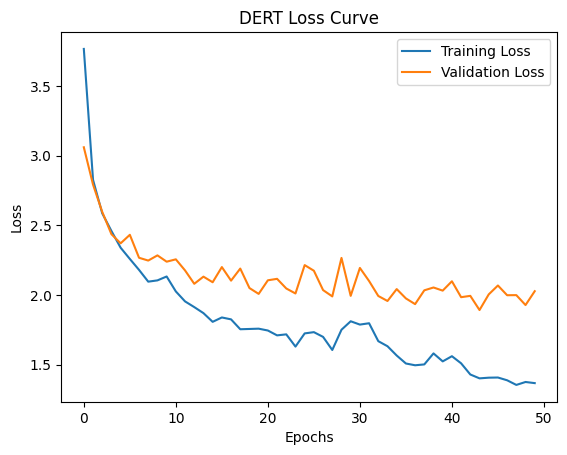

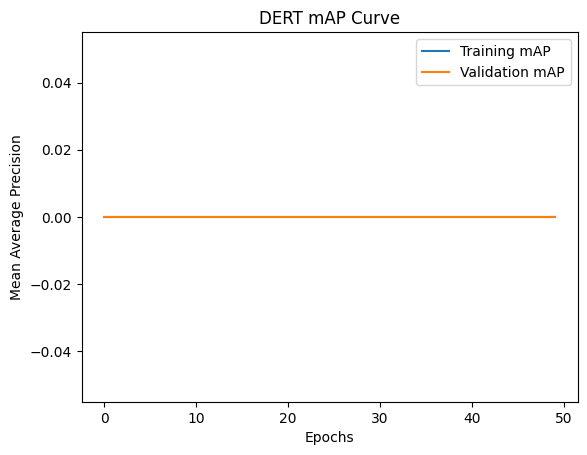

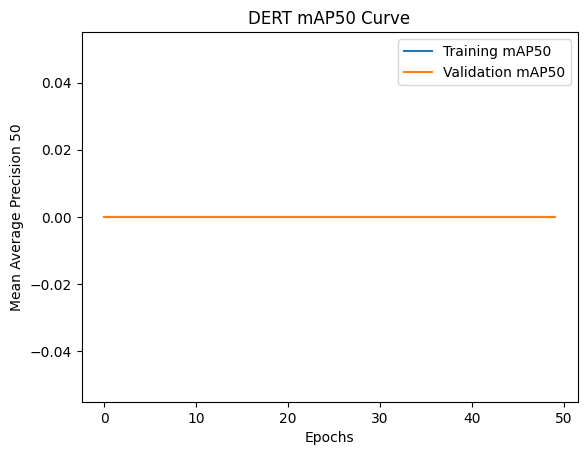

In [9]:
# Creating, saving, and displaying loss curve from training:
detr_wrapper.plot_loss_curve("DERT")

# Creating, saving, and displaying mAP curve from training:
detr_wrapper.plot_map_curve("DERT")

# Creating, saving, and displaying mAP50 curve from training:
detr_wrapper.plot_map50_curve("DERT")

In [ ]:
# Testing the model:
detr_wrapper.test(test_set)